First we import the necessary libraries.




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

Here we create two arrays $x \in \mathbb{R}^{n+1}$ and $t \in \mathbb{R}^{m+1}$, which corresponds to the discrete points in the spatial discretization of $\Omega = [0,1]$ and temporal disc. of $I=[0,1]$. $k$ denotes the step size of time discretization and $h$ denotes the step size of position discretization.

In [ ]:
h=0.01 #step size of space (x)
k=0.05 #step size of time (t)
x= np.arange(0, 1+h, h)
t= np.arange(0, 1+k, k)

m=len(t)-1
n=len(x)-1

We set boundary condition $u(0,t)=u(1,t)=0$ and the initial condition is given as $u(x,0)=\sin(\pi x)$

In [ ]:
boundaryConditions=[0,0] 
initialConditions=np.sin(np.pi*x) 

We choose the RHS function
as $f=\partial_t u_{exact} -\partial_{xx} u_{exact}$
for given $u_{exact}(x,t)= \sin(\pi x) e^{-\pi^2 t}$.
We have
\begin{align*}
\partial_t u_{exact} =& -\pi^2 \sin(\pi x) e^{-\pi^2 t}\\
\partial_{x} u_{exact} =& \pi \cos(\pi x) e^{-\pi^2 t} \\
\partial_{xx} u_{exact} =& -\pi^2 \sin(\pi x) e^{-\pi^2 t}
\end{align*}
Therefore we have
\begin{align*}
f= &\partial_t u_{exact} -\partial_{xx} u_{exact} \\
= & -\pi^2 \sin(\pi x) e^{-\pi^2 t}-(-\pi^2 \sin(\pi x) e^{-\pi^2 t})\\
= 0
\end{align*}


In [ ]:
def f_func(x,t):
  f=0
  return f
def u_exact(x,t):
  uexact=(np.sin(np.pi*x) * np.exp(-(np.pi)**2 * t)).T
  return uexact

Then we create the band matrix $A\in \mathbb{R}^{(n-1)×(n-1)}$ with its values on the band coming from the central differences method. $S=M+A$ denotes the system matrix.

In [ ]:
M=np.identity(n-1)
M*=1/k

Then we create the band matrix $A\in \mathbb{R}^{(n-1)×(n-1)}$ with its values on the band coming from the central differences method. $S=M+A$ denotes the system matrix.

In [ ]:
A=diags([-1, 2, -1], [0, 1, 2], shape=(n,n)).toarray()
A=np.delete(A, 0, 1)
A=np.delete(A, n-1, 0)
A=A/(h*h)

S=M+A

We form the matrix $F$ and the empty matrix $u$ which will then be filled with our solution.

In [ ]:
F=np.zeros((n-1,m))
u=np.zeros((n+1,m+1))

We place the given boundary and initial values in $u$.

In [ ]:
u[:,0]=initialConditions
u[0,:]= boundaryConditions[0]
u[n,:]= boundaryConditions[1]

Here we solve our system with the implicit method, $u$ now contains the numerical solutions.

In [ ]:
for j in range(m):  #t 
  u[1:n,j+1]=np.linalg.inv((S)).dot(F[:,j]+(1/k)*u[1:n,j])

We calculate the exact solution as $u_{act}$ this time.

In [ ]:
uexact=np.zeros((n+1,m+1))
for j in range(m+1):
  for i in range(n):
    uexact[i,j]=u_exact(x[i], t[j])

We lastly plot the error between the numerical solution $u$ which is coming from the implicit method and the exact solution $u_{exact}$ at $t =1$.

Text(0, 0.5, 'error')

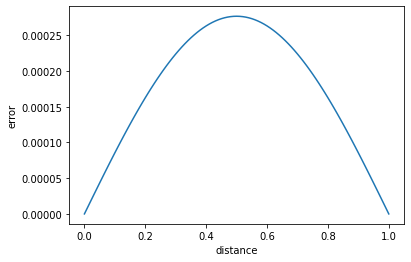

In [ ]:
plt.plot(x, u[:,m]-uexact[:,m])
plt.xlabel('distance')
plt.ylabel('error')

For error assesment we consider the following norm

$\| u_{exact} - u_h \|_{L^2(I;L^2(\Omega))}^2 = \sum_{j=0}^{m} \sum_{i=0}^{n} | u_{exact}(x_i, t_j) - u_h(x_i, t_m) |^2  $

Remember: $$\| v \|^2_{ L^2(\Omega)} = \sum_{i=0}^{n} | v(x_i) |^2 \approx \int_{\Omega} | v(x) |^2 dx$$
 $$\| w \|^2_{ L^2(I)} = \sum_{j=0}^{m} | v(x_j) |^2 \approx \int_{I} | v(t) |^2 dt$$


In [ ]:
L2L2norm_err=0;
for j in range(m):
  for i in range(n):
    L2L2norm_err += pow(u[i,j]-uexact[i,j],2)
L2L2norm_err

1.2024700018516639

For a better interpretation we also plot the actual solution $u_{exact}$. 

In [ ]:
"""for j in range(m):
  plt.plot(x, uexact[:,j], color=[R[j],G,B[j]])
plt.xlabel('x')
plt.ylabel('temperature')"""

"for j in range(m):\n  plt.plot(x, uexact[:,j], color=[R[j],G,B[j]])\nplt.xlabel('x')\nplt.ylabel('temperature')"

Text(0, 0.5, 'temperature')

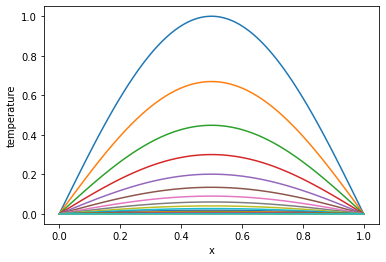

In [ ]:
for j in range(m):
  plt.plot(x, u[:,j])
plt.xlabel('x')
plt.ylabel('temperature')

Before we move on to the neural network we want to have a solution matrix $u_{exact}$ in which each column represents time and each raw represent position. For instance, the first column of $u_{exact}$ consist of $\big(u_{exact}(x_{0},t_{0}),u_{exact}(x_{1},t_{0}), \cdots, u_{exact}(x_{100},t_{0}) \big)^T$

In [ ]:
xv, tv = np.meshgrid(x, t)

Let's continue with Neural Network implementation.

First, we import additional required librarires.

In [ ]:
import torch
import math
from torch import tensor, cat

To predict $u_{m}$ , we give the solution vector at $u_{m-1}$ as the input of the Neural Network. 

In this case, we have input and output layers with number of nodes equal to $n$. And $m$ data in total (for test + training).

We divide our $m$ data to train and test sets and give the size of train data with $trsize$.


In [ ]:
factor=0.5
trsize=int((u.shape[1]-1)*factor)
trsize

10

We want to give the inputs to the network sequentially on temporal domain. Instead of giving data as discrete vector pairs, we form two matrices and take the inputs column by column.

In [ ]:
# Training Data sets 
input_train_dataset=torch.Tensor(u[:,0:trsize].T)  
output_train_dataset =torch.Tensor(u[:,1:trsize+1].T)


In order to create a Residual Neural Network which is similar to the structure given in the script we defined the following class $DNN$. It takes $6$ parameters $n_{in}, n_1, n_2, n_{out},$ *learning_rate, weight_decay*; the number of nodes in the input, first hidden layer, second hidden layer and output layers, learning rate and weight decay respectively. We use Sigmoid as activation function. 


The loss function is the classical default function Mean Squared Error. $$\sum_{i=1}^{m}(u_{h}(x,t_i)-u(x,t_i))^2$$

Then we define the $forward$ function which simply returns the residual network where, P, $ g[P](x)$ and $ f[P](x)$ represents the hyperparameter choices, the ResNet and the core network respectively: $$ g[P](x) = x + f[P](x)$$


In [ ]:
class DNN(torch.nn.Module):
    def __init__(self, n_in, n1, n2, n_out, learning_rate=1e-2, weight_decay=0):
        super().__init__()
        self.net = torch.nn.Sequential(
          torch.nn.Linear(n_in, n1),
          torch.nn.Sigmoid(),
          torch.nn.Linear(n1, n2),
          torch.nn.Sigmoid(),
          torch.nn.Linear(n2, n_out),
      )
        self.loss_fn = torch.nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
      

    def forward(self, x):
        nx = self.net(x)
        return x + nx
        #return x + 0.5 * k * nx + 0.5 * k * self.net(x + 0.5 * k * nx)

    def train_model(self, x, y, epochs, learning_rate=1e-2, weight_decay=0):
      loss_values = []
      
      for i in range(epochs):
          pred = self(x)
          loss = self.loss_fn(pred, y)
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
          loss_values.append(loss.item())
      
      return loss_values

We create an object $model1$ from the class $DNN$. Our model has $n$ number of nodes in its input and output layers which is the size of input vectors, 20 nodes each in the hidden layers and a learning rate of $0.01$.

In [ ]:
model1 = DNN(n_in=n+1, n1=20, n2=20, n_out=n+1, learning_rate=1e-2)

We train the model by running for $10000$ epochs with our above formed training datasets.

In [ ]:
loss_values_train= model1.train_model(input_train_dataset, output_train_dataset, 10000)

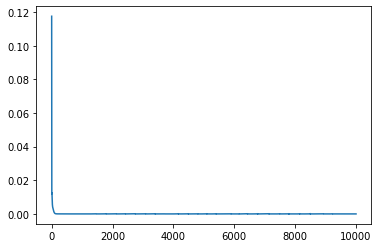

In [ ]:
plt.plot(loss_values_train)

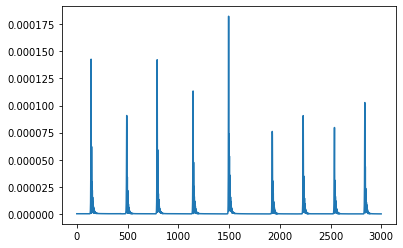

In [ ]:
plt.plot(loss_values_train[7000:])

A new matrix for the neural network solution is defined as $output$. We fill in the part containing the training data with the exact solutions and then fill the rest of the range which corresponds to the test data with neural network predictions.

In [ ]:
output = torch.zeros(m+1,n+1)
output[0:trsize,:] = torch.Tensor(u[:, 0:trsize]).T

for i in range(trsize,m):
  output[i] = model1(output[i-1])

We first plot the exact solution.

Text(0, 0.5, 'temperature')

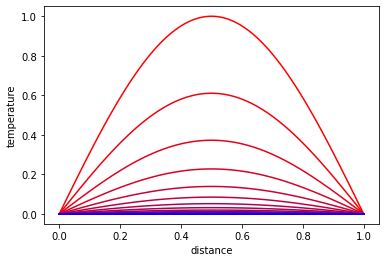

In [ ]:
R=np.linspace(1,0,m+1)  
B=np.linspace(0,1,m+1)
G=0
 
for j in range(m+1):
  plt.plot(x, uexact[:, j], color=[R[j],G,B[j]])
#plt.legend([f't={value}' for value in t])
plt.xlabel('distance')
plt.ylabel('temperature')


Now, let's see the neural network solution. The output tensor has the exact values for the training part of the temporal domain and the network solutions for the test part.

Text(0, 0.5, 'temperature')

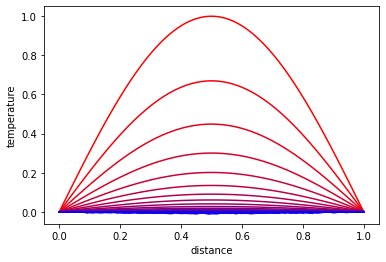

In [ ]:
R=np.linspace(1,0,m+1)  
B=np.linspace(0,1,m+1)
G=0
for j in range(m+1):
  plt.plot(x, output[j].detach().numpy(), color=[R[j],G,B[j]])
plt.xlabel('distance')
plt.ylabel('temperature')


We calculate the error.

In [ ]:
err_1 = output.detach().numpy() - uexact.T
err_2 = u.T - uexact.T



And we plot the error at each time.

Text(0, 0.5, 'error')

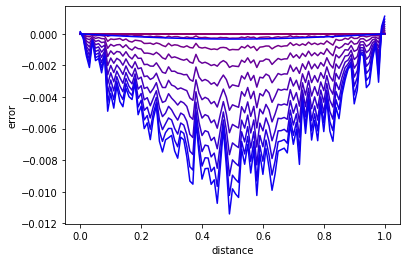

In [ ]:
R=np.linspace(1,0,m+1)  # just plot the solution
B=np.linspace(0,1,m+1)
G=0
for j in range(m+1):
  plt.plot(x, err_1[j,:].T-err_2[j,:].T, color=[R[j],G,B[j]])
#plt.legend([f't={value}' for value in t])
plt.xlabel('distance')
plt.ylabel('error')


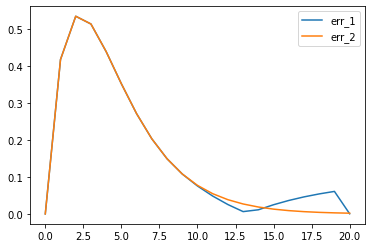

In [ ]:
plt.plot(np.linalg.norm(err_1, axis=1),label='err_1')
plt.plot(np.linalg.norm(err_2, axis=1),label='err_2')
plt.legend()
plt.show()

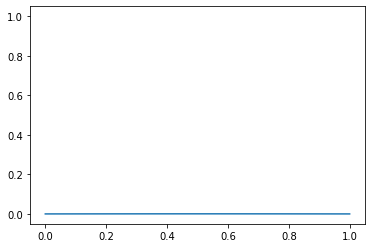

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()
x= np.arange(0, 1+h, h)
line, = ax.plot(x,u[:,0])


def animate(i):
    line.set_ydata(u[:,i])  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, frames=m, interval=100, blit=True)

ani.save("movie.mp4")

#plt.show()